## Kutuphaneler ##

In [269]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
import scipy.stats as stats
import pylab
warnings.filterwarnings('ignore')
from dateutil.relativedelta import *
import calendar
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
plt.style.use('seaborn')

In [270]:
df = pd.read_excel('Veri-Seti.xlsx')
df.dropna(inplace=True)

## KEŞİF ANALİZİ ## 


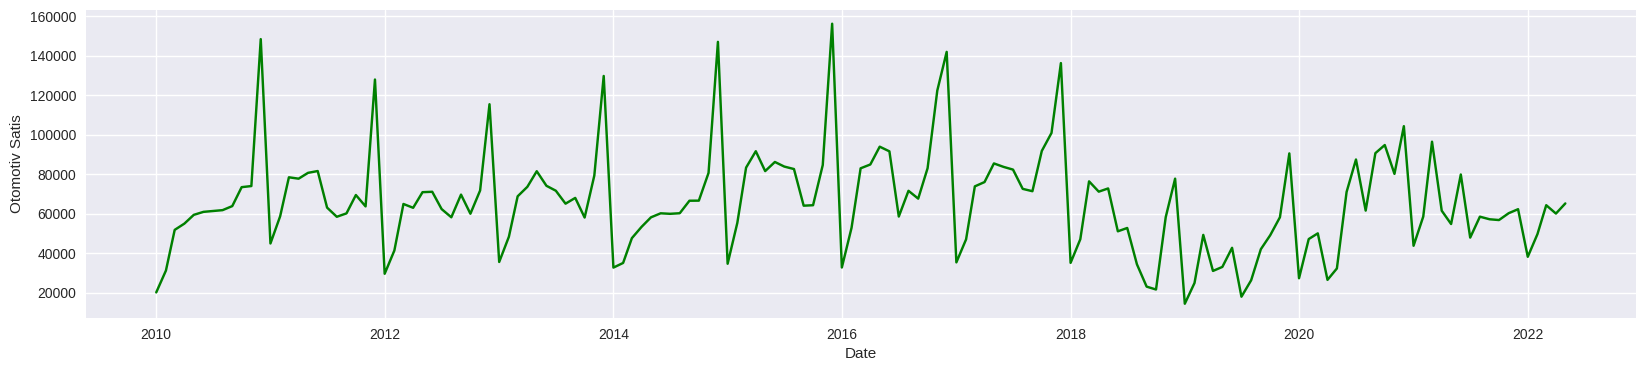

In [271]:
plt.figure(figsize=(20,4))
sns.lineplot(data=df,x='Date',y='Otomotiv Satis',color='g')
plt.show()

Hedef değiskenine bakildiginda cok belirgin bir sezonsallik goze çarpiyor.Bu durum, modelin en önemli bağimsiz değiskenlerinden birinin zaman olacagi ipucunu veriyor. 

In [272]:
print('Kolonlardaki Null degerlerin sayisi:')
df.isnull().sum()

Kolonlardaki Null degerlerin sayisi:


Date              0
Otomotiv Satis    0
OTV Orani         0
Faiz              0
EUR/TL            0
Kredi Stok        0
dtype: int64

In [273]:
print('Kolonlarin Istatistik Bilgileri:')
df.describe().T

Kolonlarin Istatistik Bilgileri:


,count,mean,std,min,25%,50%,75%,max
Otomotiv Satis,149.0,6.590262e+04,2.617580e+04,14373.000000,50008.000000,6.304400e+04,7.981900e+04,1.561730e+05
OTV Orani,149.0,4.369799e+01,5.846811e+00,37.000000,40.000000,4.500000e+01,5.000000e+01,6.500000e+01
Faiz,149.0,1.603438e+01,5.319518e+00,9.607500,12.715000,1.448500e+01,1.747500e+01,3.278250e+01
EUR/TL,149.0,4.808703e+00,3.321767e+00,1.927305,2.464018,3.276861e+00,6.380609e+00,1.656000e+01
Kredi Stok,149.0,1.787554e+06,1.176366e+06,341244.126000,775545.498000,1.474594e+06,2.447479e+06,4.862887e+06


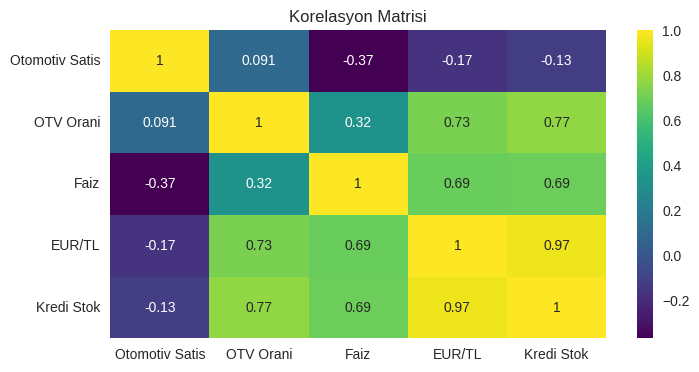

In [274]:
cor = df.corr()
plt.figure(figsize=(8,4))
plt.title('Korelasyon Matrisi')
sns.heatmap(cor,annot=True,cmap='viridis')
plt.show()

Korelasyon Matrisine bakildiginda 'EUR/TL' ~ 'Kredi Stok' arasinda ciddi bir pozitif korelasyon görülüyor. Ayni zamanda 'OTV Orani' da bu ikiliyle ileri derecede korele. Değişken seçerken bu korelasyon değerleri göz önüne alinmalidir.  Aralarinda yüksek korelasyon bulunan değişkenlerden birinin elenmesi genelde model performansini arttirir.

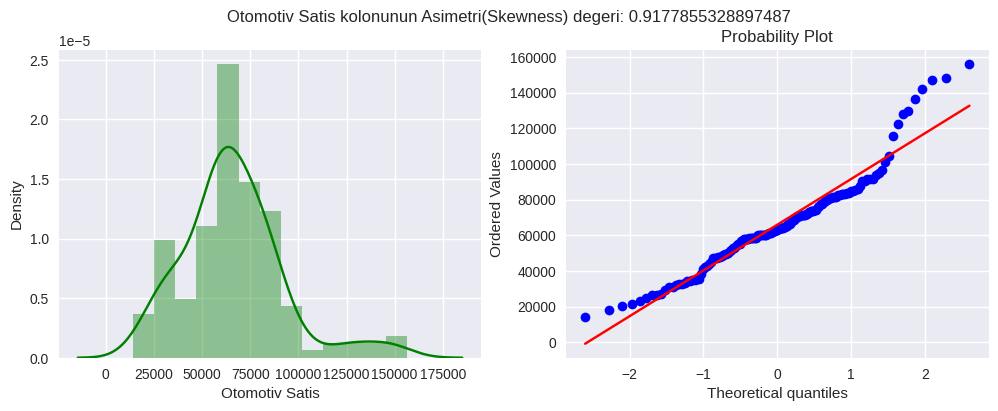

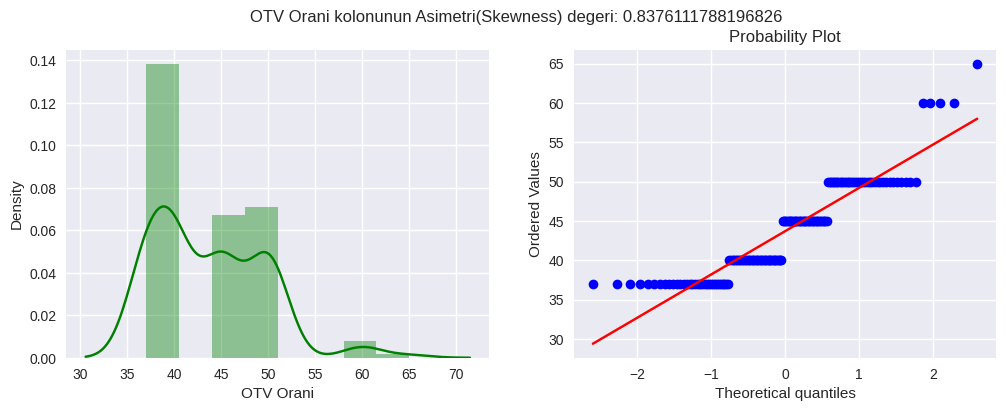

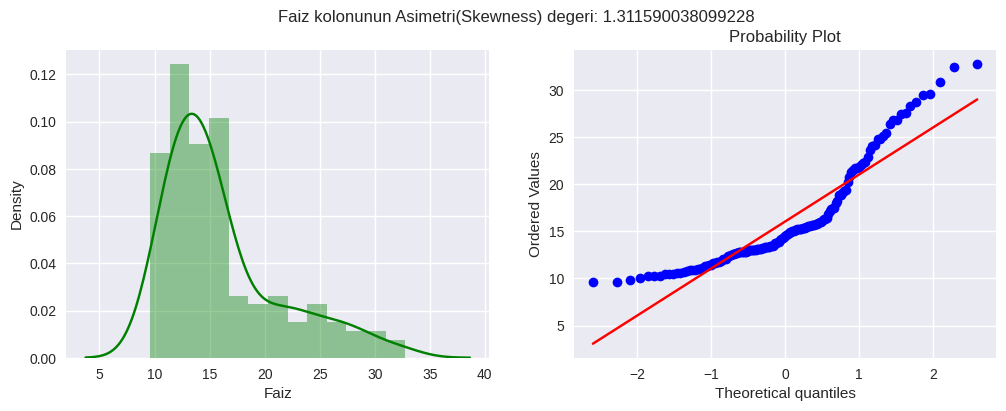

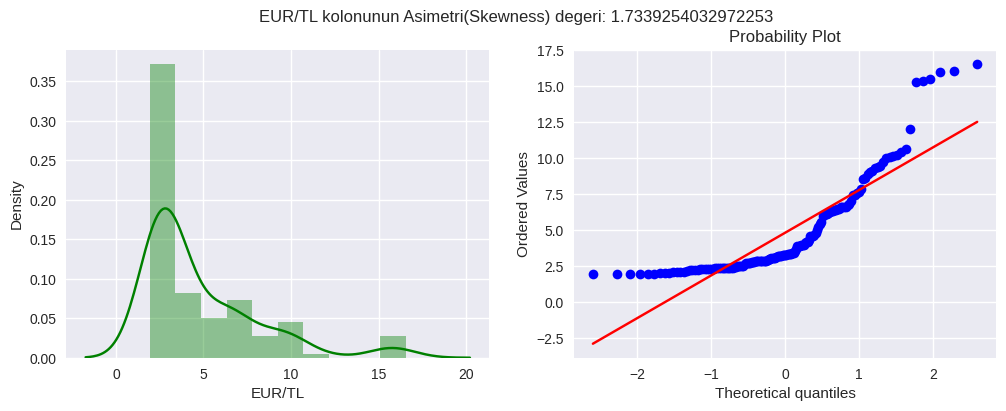

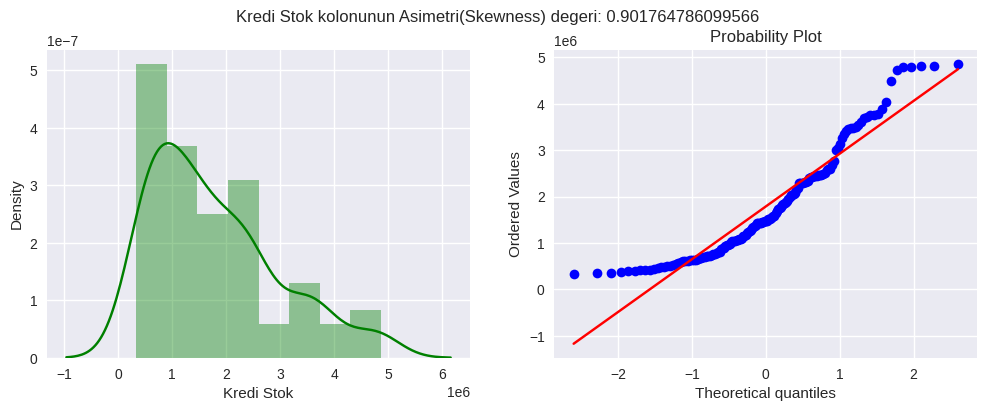

In [275]:
def check_distribution(data,col):
   plt.figure(figsize=(12,4))
   plt.suptitle(f'{col} kolonunun Asimetri(Skewness) degeri: {data[col].skew()}')
   plt.subplot(1,2,1)
   sns.distplot(data[col],color='g')
   plt.subplot(1,2,2)
   stats.probplot(data[col],plot=pylab)
   plt.show()

asimetri_once = dict()
for kolon in df.columns[1:]:
   check_distribution(df, kolon)
   asimetri_once[kolon] = df[kolon].skew()
asimetri_once =  pd.DataFrame(asimetri_once,index = ['Önce']).iloc[:,1:]

Bir fonksiyon olusturup kolonlarin dagilimlari gorsellestirildiginda verinin genelde asimetrik dagilima sahip oldugu görülüyor.
Veri kolonlarinin dagilimlarinin normale yakin olmasi model performansini artiracak unsurlardan biri oldugundan kolon dagilimlarini normale(Gaussian) yaklastirmak icin farkli transformer fonksiyonlar uygulanmali.

## MODELLEME ÖNCESİ ##

In [276]:
df['season'] = df.Date.apply(lambda x:calendar.month_name[x.month])
df2 = pd.concat([df,pd.get_dummies(data =df['season'])],axis=1).drop(columns=['season']).drop(columns=['Date'])
# df2 = pd.get_dummies(data=df,columns=['season'],prefix='').set_index('Date')
df2.head(3)

,Otomotiv Satis,OTV Orani,Faiz,EUR/TL,Kredi Stok,April,August,December,February,January,July,June,March,May,November,October,September
0,20095.0,37.0,13.1820,2.107385,341244.126,0,0,0,0,1,0,0,0,0,0,0,0
1,31172.0,37.0,13.2725,2.073890,351940.949,0,0,0,1,0,0,0,0,0,0,0,0
2,51769.0,37.0,12.7275,2.085522,361307.320,0,0,0,0,0,0,0,1,0,0,0,0


Burada tarih kolonundaki ay isimlerini kullanarak yeni bir kolon oluşturdum. Ve bu kolonu da OHE yontemiyle binary kolonlara cevirdim. Bu sekilde her farkli ayin model ustundeki etkisini daha iyi görebilecegiz. Yukarida da bahsettigim gibi tarih kolonu tahminlemelerde onemli rol oynayacak. 

In [277]:
df2['EUR/TL'] = 1/df2['EUR/TL']
df2['Faiz'] = 1/df2['Faiz']
df2['Kredi Stok'] = np.log(df2['Kredi Stok'])
df2['OTV Orani'] = 1/df2['OTV Orani']
asimetri_sonra = dict() 
kolonlar = df2.iloc[:,1:5].columns
for col in kolonlar:
    asimetri_sonra[col] = df2[col].skew()

asimetri_sonra_frame = pd.DataFrame(asimetri_sonra,index=['Sonra'])
asimetri_degisimi=pd.concat([asimetri_sonra_frame,asimetri_once])
asimetri_degisimi

,OTV Orani,Faiz,EUR/TL,Kredi Stok
Sonra,-0.281076,-0.237477,-0.053793,-0.180827
Önce,0.837611,1.311590,1.733925,0.901765


Daha once asimetri degerlerin verdigim kolonlari normal dagilima sahip hale getirmek icin farkli donusum fonksiyonlari uyguladim. Bu kisimda farkli donusum methodlari arasinda deneme-yanilma yaparak en iyi degerleri bulmaya calistim. Kolonlarin asimetrik yapisi buyuk oranda duzeldi. 

In [278]:
x = df2[['OTV Orani','Faiz','EUR/TL','Kredi Stok','August','December', 'February', 'January', 'June','November']]
y = df2.iloc[:,0]
# scaler = StandardScaler()
# x = scaler.fit_transform(x)
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=23, test_size= 0.1)

Yine deneme yanilma yöntemiyle bazi aylari performansi dusurdukleri icin modelde kullanmamaya karar verdim. Modele katilan aylar ise tahmin uzerinde cok dominant.
Bağimsiz değişkenleri seçtikten veriyi test-train, hedef değişken-bağimsiz değişken olarak ayirdim. Veri modelleme icin hazir.  

## MODEL ##

Results for LinearRegression :
Mean absolute error: 7220.476826609958
Mean absolute percentage error: 0.11798327916957445



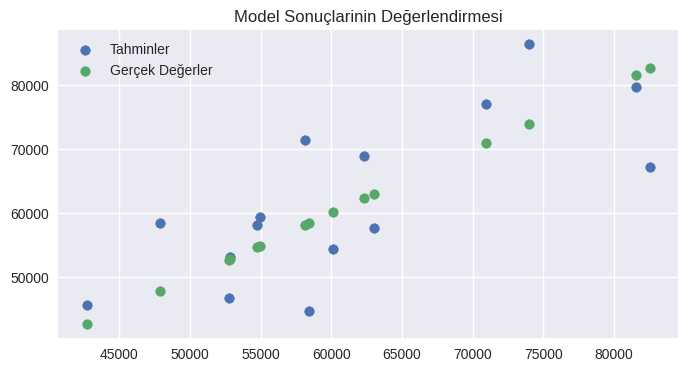

In [279]:
model = LinearRegression()
model.fit(x_train,y_train)
y_hat = model.predict(x_test)
print(f'Results for',str(model)[:-2],':')
print(f'Mean absolute error:',mean_absolute_error(y_test,y_hat))
print(f'Mean absolute percentage error:',mean_absolute_percentage_error(y_test,y_hat))
print()
plt.figure(figsize=(8,4))
plt.title('Model Sonuçlarinin Değerlendirmesi')
plt.scatter(x=y_test,y=y_hat,label = 'Tahminler')
plt.scatter(x = y_test, y= y_test,label = 'Gerçek Değerler')
plt.legend()
plt.show()

Toplam verinin %10'u kadarlik bir test seti ayirdigimda modelin performans sonuçlari yukaridaki gibi oldu. Test verisi değistikçe yukaridaki sonuçlar da degişse de, model ortalama olarak %15'lik bir sapma ile tahminleme yapiyor.
Ayni zamanda görsel olarak da tahminler ve gercek sonuclarin karşilastirmasini yaptim.

In [280]:
pickle.dump(model, open('lin_reg.pkl', 'wb'))    ## Modeli API'da kullanmak için kaydet.

Mean Absolute Percentage Error: 0.1788828023308051


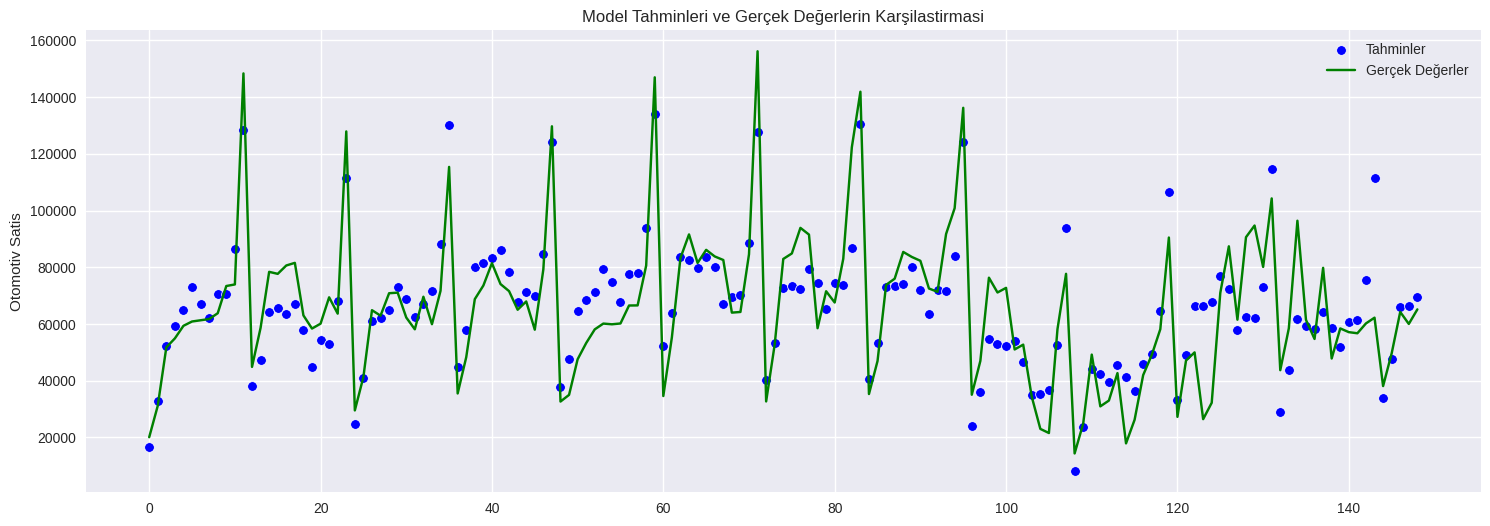

In [281]:
preds=model.predict(x)
plt.figure(figsize=(18,6))
plt.title('Model Tahminleri ve Gerçek Değerlerin Karşilastirmasi')
sns.scatterplot(y = preds,x=x.index,color='b')
sns.lineplot(y=y,x=x.index,color='g')
plt.legend(labels=['Tahminler', 'Gerçek Değerler'])
print(f'Mean Absolute Percentage Error:',mean_absolute_percentage_error(y,preds))
plt.show()

## 2022 Haziran - 2023 Haziran Tahmini ##

İleri yönlü tahmin yapabilmek icin elimde tarih değiskeninden başka veri yok. Diger parametrelerin nerede olacağini bilmiyorum. Bu yüzden gecmisteki satış miktarini kullanip gelecekteki satış miktarini tahmin eden bir model kurdum. Önceki ayin verisini sezonsallikla birleştirince sonuçlar ümit verici oldu. Modelin çalışma mantığı şu şekilde;
- Veri setindeki ay isimleri ve geriye ötelenmiş satış miktari verilerini bağımsız değişken olarak kullan ve modeli train et, 
- Veri setindeki en son satir icin bir tahmin yap ve o yapilan tahmini gelecek gün için modelde satış miktari değişkeni olarak kullan,
- Ayni adimi tahmini yapilmasi istenen tarihe kadar devam ettir.
Böylece, model kendi sonuçlarini kullanarak uzun vadeli tahminler yapabilir. Tarih değiskeninden gelen veri ile de belli bir sezonsallik yakalayabilir. 

In [282]:
df_new = pd.read_excel('/home/jess/Downloads/Veri-Seti.xlsx')                       # Veriyi yükle
datesx = [df_new.Date.tolist()[-1] + relativedelta(months=+x) for x in range(12)]   # Tarih kolonunu uzatmak icin yeni bir seri olustur
extension =pd.DataFrame(index = range(162,174), data= datesx,columns=['Date'])      # Olusturulan seriyi pandas data frame objesine cevir
df_new=pd.concat([df_new,extension],axis=0)                                         # Verinin tarih kolonunu birer ay ekleyerek belli bir hedefe kadar uzat.     
df_new['month'] =df_new.Date.apply(lambda x:calendar.month_name[x.month])           # Tarih kolonundan ay isimlerini çıkar.
df_new = pd.get_dummies(data=df_new,columns = ['month'], prefix = '')               # Ay isimlerinin oldugu kolonu OHE kullanarak binary kolonlara dönüştür
df_new = df_new.set_index('Date',drop=True)                                         # Tarih kolonunu sil.
df_new['sales'] = df_new['Otomotiv Satis'].shift(1)                                 # Otomotiv satis kolonunu ötele ve bir periyot onceki veriyi değişken olarak kullan
train_data = df_new.iloc[:149]                                                      # Veriyi train ve test olarak ayır.
test_data = df_new.iloc[149:]
x_train,y_train = train_data.iloc[:,-13:], train_data.loc[:,'Otomotiv Satis']       # Veriyi hedef değişkeninden ayır.
x_test, y_test = test_data.iloc[:,-13:], test_data.loc[:,'Otomotiv Satis']              
y_train = y_train.iloc[1:,]
x_train.dropna(inplace=True)                                                        # Null degeri olan satirlari sil. 
x_train.head(3)

,_April,_August,_December,_February,_January,_July,_June,_March,_May,_November,_October,_September,sales
Date,,,,,,,,,,,,,
2010-02-01,0,0,0,1,0,0,0,0,0,0,0,0,20095.0
2010-03-01,0,0,0,0,0,0,0,1,0,0,0,0,31172.0
2010-04-01,1,0,0,0,0,0,0,0,0,0,0,0,51769.0


In [283]:
predictions = []                                             # Tahminlerin kaydedilecegi bir liste oluştur. 
dates = []                                                   # Tarihlerin kaydedilecegi bir liste oluştur. 
date_row = x_train.iloc[-1:]                                 # Veri setinin son satirina değişken ata.
indexx =x_train.index[-1]                                    # Veri setinin son satirinin indexini bul.
model.fit(x_train,y_train)                                   # Modeli eğit
for i in range(12):                                          # Istenilen periyot sayisi kadar tekrar etmek icin bir döngü fonksiyonu oluştur.                              
    predicted = model.predict(date_row)                      # Güncel girdiler icin tahmin yap.
    predictions.append(predicted[0])                         # Tahmini yukarida yaratilan listeye ekle. 
    indexx = indexx + relativedelta(months=+1)               # Güncel tarihin üzerine bir ay ekle.
    dates.append(indexx)                                     # Yeni olusturulan tarihi yukarida olusturulan listeye ekle.
    date_row = x_test[x_test.index == indexx].values[0][:-1] # Yeni olusturulan tarihe esit olan satirdaki aylarin degerlerini al. Son kolon olan satis miktarini alma
    date_row =  np.concatenate([date_row,predicted])         # Alinan zaman kolonlarini döngü fonskiyonun güncel turunda yaptigi tahminle birlestir ve yeni bir satir olustur.
    date_row = date_row.reshape(1,-1)                        # Olusturulan satiri istenen formata getir.

Yukaridaki döngüde 12 defa tahmin yapildi ve her tahmin icin bir onceki tahmin ve tarih verileri girdi olarak kullanildi. Sonuclari gorsellestirdigimizde is asagidaki tablo ortaya cikiyor.

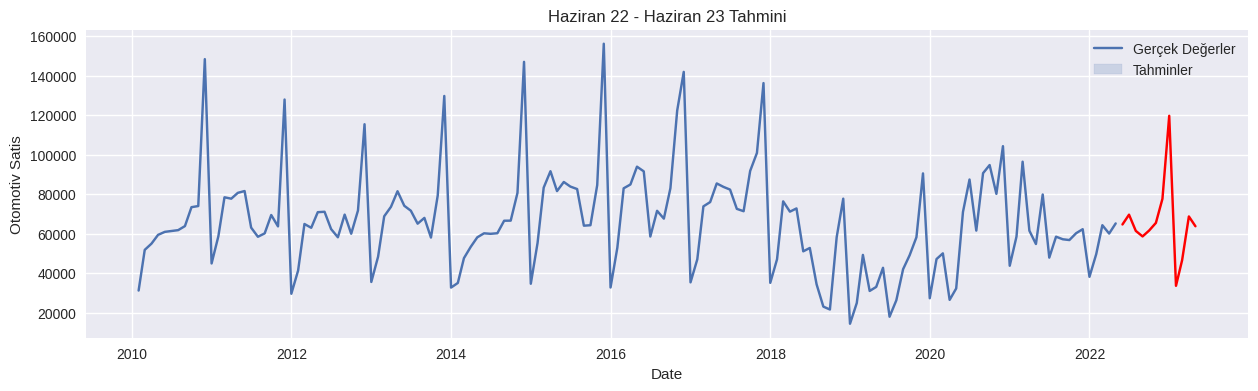

In [284]:
plt.figure(figsize=(15,4))
plt.title('Haziran 22 - Haziran 23 Tahmini')
sns.lineplot(x=x_train.index,y= y_train )
sns.lineplot(x= dates, y = predictions,color = 'red')
plt.legend(labels=['Gerçek Değerler','Tahminler'])
plt.show()